In [1]:
import matplotlib.pyplot as plt
import seaborn

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import import_ipynb
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#import model
%cd ..
%cd "protein-ppi-encoding-module"
from transformerGO import *

%cd .. 
%cd "training-testing"
from training_helper import * 

#import dataset functions
%cd ..
%cd "datasets"
from dataset_manip import *
%cd .. 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available: ", device, " ", torch.cuda.get_device_name(0))

#for np array from nested sequences
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO
C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO\protein-ppi-encoding-module
importing Jupyter notebook from transformerGO.ipynb
importing Jupyter notebook from harvard_transformer.ipynb
C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO
C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO\training-testing
importing Jupyter notebook from training_helper.ipynb
C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO
C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO\datasets
importing Jupyter notebook from dataset_manip.ipynb
C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO
Device available:  cuda   GeForce GTX 960M


In [2]:
organism = 4932
EMB_DIM = 64

data_path = 'datasets/onto2vec-datasets-string/data'
go_embed_pth = f"term-encoding-module/emb/go-terms-{EMB_DIM}.emd"
go_id_dict_pth = "term-encoding-module/go_id_dict"
protein_go_anno_pth = data_path +"/sgd.gaf.gz"
alias_path = data_path + f'/{organism}.protein.aliases.v11.0.txt.gz'

neg_path_train = data_path + f'/train/{organism}.no-mirror.negative_interactions.txt'
poz_path_train = data_path + f'/train/{organism}.no-mirror.protein.links.v11.0.txt'

train_set = get_dataset_split_stringDB(poz_path_train, neg_path_train, protein_go_anno_pth, go_id_dict_pth, go_embed_pth, None, alias_path, ratio = [1, 0, 0], stringDB = True)[0]
print("Train set: ", len(train_set))

def helper_collate(batch):
    MAX_LEN_SEQ = get_max_len_seq(batch)
    return transformerGO_collate_fn(batch, MAX_LEN_SEQ, EMB_DIM, pytorch_pad = False)

params = {'batch_size': 32,'collate_fn': helper_collate}
train_grt = data.DataLoader(train_set, **params, shuffle = False)

Rejected interactions where at least one protein has no annotation:  3637
Rejected interactions where go_filter=ALL and intr_set_size_filter=[0, 500]:  0
Number of interactions: 72556
Rejected interactions where at least one protein has no annotation:  18633
Rejected interactions where go_filter=ALL and intr_set_size_filter=[0, 500]:  0
Number of interactions: 57560
Train set:  130116


Annotations of protein 4932.YGR189C: ('GO:0006037', 'GO:0009277', 'GO:0031505', 'GO:0016757', 'GO:0071944', 'GO:0000131') 

Annotations of protein 4932.YGR171C: ('GO:0004825', 'GO:0005739', 'GO:0006431')
Encoder Layer 1


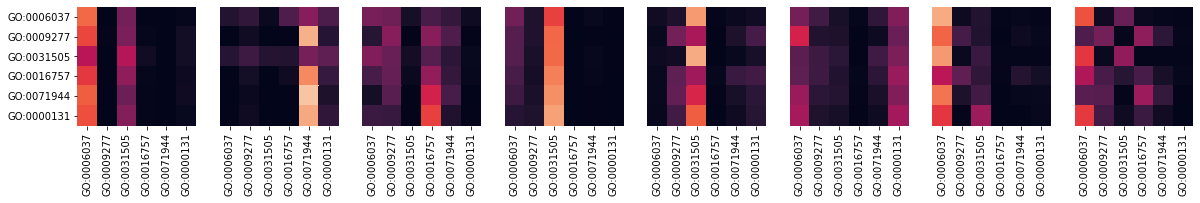

Encoder Layer 2


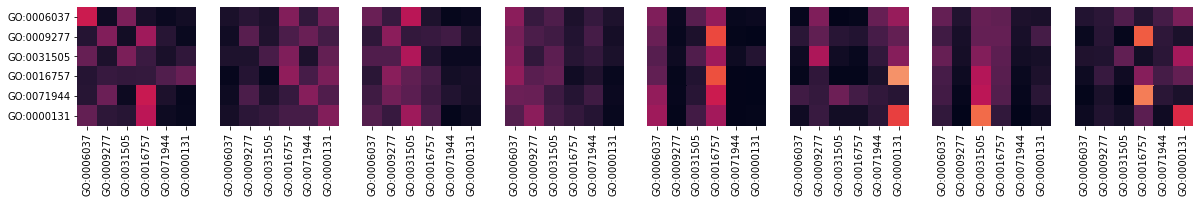

Encoder Layer 3


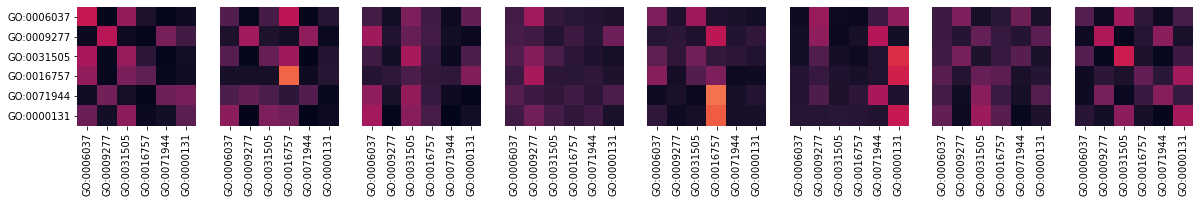

Decoder Self Layer 1


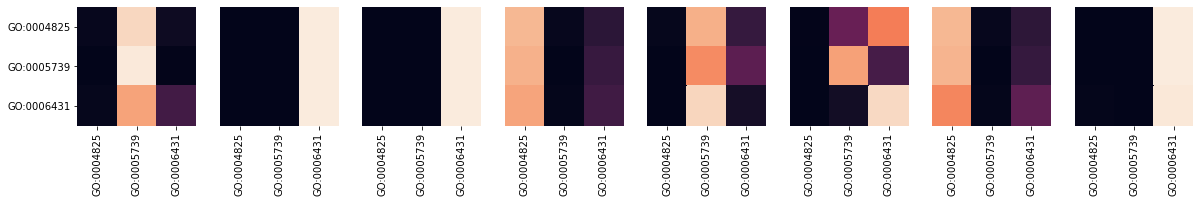

Decoder Src Layer 1


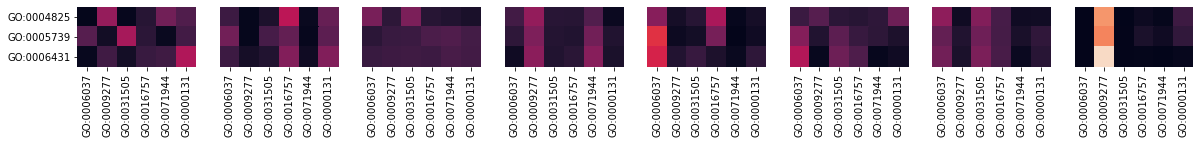

Decoder Self Layer 2


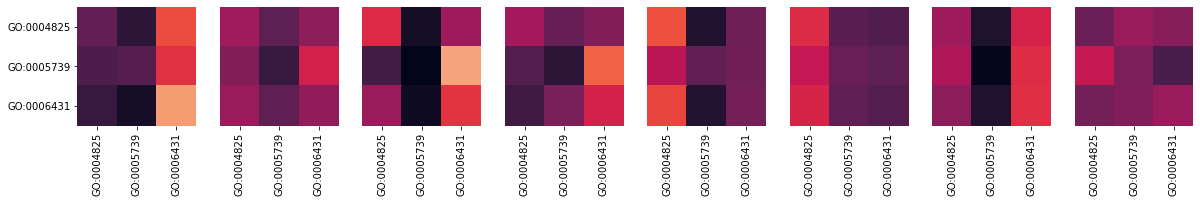

Decoder Src Layer 2


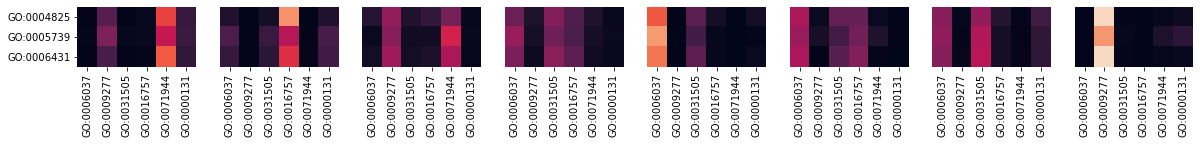

Decoder Self Layer 3


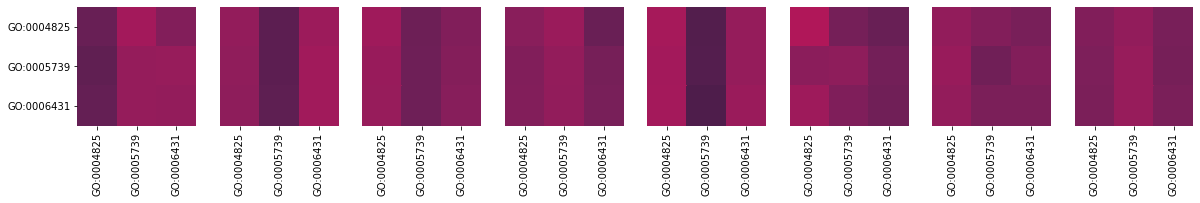

Decoder Src Layer 3


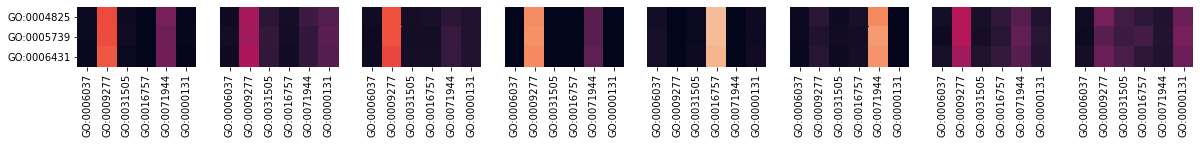

In [11]:
MODEL_SIZE = 64
NR_HEADS = 8
NR_LAYERS = 3
DROPOUT = 0.3
SIZE_FF = 4 * MODEL_SIZE

model = TransformerGO_Scratch(MODEL_SIZE, NR_HEADS, NR_LAYERS, SIZE_FF, DROPOUT)
model.load_state_dict(torch.load(r'saved-models/model-yeast-stringDB-benchmark-noMirror.pt'))
model = model.to(device)

model.eval()
with torch.no_grad():
    for batch in train_grt:
            
        #padded pairs: tensor of shape N * 2(protein pair) * L(longest seq) * Emb dim
        padded_pairs = batch[0].to(device)
        labels = batch[1].to(device)
        mask = batch[2].to(device)
        batch_ids = batch[3]
        
        #swap seqLen with batch to fit the transformer
        gosetA_batch = padded_pairs[:,0]
        gosetB_batch = padded_pairs[:,1]
            
        protA = batch_ids[0][0][1]
        protB = batch_ids[0][1][1]
        print(f"Annotations of protein {batch_ids[0][0][0]}:", protA , '\n')
        print(f"Annotations of protein {batch_ids[0][1][0]}:", protB )
        predictions = model(gosetA_batch[0].unsqueeze(0), gosetB_batch[0].unsqueeze(0), mask[0,0].unsqueeze(0), mask[0,1].unsqueeze(0)).squeeze(1)
        break

def draw(data, x, y, ax):
    data = data.cpu().numpy()
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(0, 3):
    fig, axs = plt.subplots(1,8, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(8):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data[:len(protA), :len(protA)], 
            protA, protA if h == 0 else [], ax=axs[h])
    plt.show()

for layer in range(0,3):
    fig, axs = plt.subplots(1,8, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(8):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(protB), :len(protB)], 
            protB, protB if h == 0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,8, figsize=(20, 10))
    for h in range(8):
        draw(model.decoder.layers[layer].src_attn.attn[0, h].data[:len(protB), :len(protA)], 
            protA, protB if h == 0 else [], ax=axs[h])
    plt.show()